In [1]:
# Imports
import os
import pandas as pd
import numpy as np
import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from sklearn.metrics import r2_score
from IPython.display import HTML, display

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
display(HTML("<style>.container { width: 90% !important; }</style>"))
warnings.simplefilter('ignore')
N_JOBS = -1
SEED = 2017

In [2]:
# Stack all single Level 1 models OOF and test preds as entries for a Level 2 model
def get_level_one_data() :
    level_one_preds = pd.DataFrame()
    i = 0
    root_dir = "oof_preds/"
    for file_name in sorted(os.listdir(root_dir)) :
        preds_OOF = pd.read_csv(root_dir + file_name)
        cur_preds_OOF = pd.Series(preds_OOF.y, name = file_name[0:7])
        level_one_preds = pd.concat([level_one_preds, cur_preds_OOF], axis = 1)
        i += 1
    display(level_one_preds.head())

    level_one_targets = pd.DataFrame()
    i = 0
    root_dir = "oof_targets/"
    for file_name in sorted(os.listdir(root_dir)) :
        targets_OOF = pd.read_csv(root_dir + file_name)
        cur_targets_OOF = pd.Series(targets_OOF.y, name = file_name[0:7])
        level_one_targets = pd.concat([level_one_targets, cur_targets_OOF], axis = 1)
        i += 1
    display(level_one_targets.head())

    # Same for test set preds
    level_one_test = pd.DataFrame()
    i = 0
    root_dir = "preds/"
    for file_name in sorted(os.listdir(root_dir)) :
        preds_test = pd.read_csv(root_dir + file_name)
        cur_preds_test = pd.Series(preds_test.y, name = file_name[0:7])
        level_one_test = pd.concat([level_one_test, cur_preds_test], axis = 1)
        i += 1
    display(level_one_test.head())
    
    return(level_one_preds, level_one_targets, level_one_test)

In [25]:
# Plot predictions
def plot_preds(targets, preds) :
    plt.style.use("fivethirtyeight")
    plt.figure(figsize=(10, 4))
    colormap = plt.cm.gist_rainbow
    plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, len(preds))])
    plt.plot([50, 250], [50, 250], c = "red", linewidth = 2)
    for i in range(len(preds)) :        
        plt.scatter(targets[i], preds[i], marker = "o", s = 5, label = "Model" + str(i + 1))
    plt.xlabel("Real y")
    plt.ylabel("Projected y")
    plt.legend()
    plt.show()

In [26]:
# Define function to minimize
def target_func(weights) :
    final_pred = 0
    for weight, pred in zip(weights, preds_X_test):
        final_pred += weight * pred
    return(-r2_score(targets_X_test[0], final_pred))


# Optimize ensemble weights on held out fold
def optimize(preds_X_test) :
    scores = []
    weights = []
    for i in range(100):
        # Choose many random starting weights
        starting_values = np.random.uniform(size = len(preds_X_test))

        # Our weights are bound between 0 and 1
        bounds = [(0, 1)] * len(preds_X_test)

        res = minimize(
            target_func, 
            starting_values, 
            method = "SLSQP", 
            bounds = bounds, 
            options = {"maxiter" : 10000})

        scores.append(res["fun"])
        weights.append(res["x"])

    bestSC = -np.min(scores)
    bestWght = weights[np.argmin(scores)]

    print("\n Ensemble Score: {}".format(bestSC))
    print("\n Best Weights: {}".format(bestWght))

    return(bestSC, bestWght)

<b>Script</b>

In [27]:
# Get data
init_test = pd.read_csv("raw_data/test.csv")
test_ids = init_test.ID.values


In [28]:
# Create Level 2 inputs
level_one_preds, level_one_targets, level_one_test = get_level_one_data()

,et_dc15,et_dc16,et_dc17,et_dc18,xg_dc15,xg_dc16,xg_dc17,xg_dc18
0,94.137,93.734,94.012,93.810,93.682,94.276,93.945,94.053
1,93.899,94.226,93.928,94.115,93.959,95.249,93.869,96.174
2,93.594,93.642,93.542,93.658,91.028,91.669,90.933,91.814
3,93.972,93.755,94.024,93.811,89.190,91.338,90.022,90.749
4,94.246,93.829,94.300,93.892,94.379,93.501,94.018,93.164


,et_dc15,et_dc16,et_dc17,et_dc18,xg_dc15,xg_dc16,xg_dc17,xg_dc18
0,99.150,99.150,99.150,99.150,99.150,99.150,99.150,99.150
1,91.980,91.980,91.980,91.980,91.980,91.980,91.980,91.980
2,91.520,91.520,91.520,91.520,91.520,91.520,91.520,91.520
3,91.570,91.570,91.570,91.570,91.570,91.570,91.570,91.570
4,90.110,90.110,90.110,90.110,90.110,90.110,90.110,90.110


,et_dc15,et_dc16,et_dc17,et_dc18,xg_dc15,xg_dc16,xg_dc17,xg_dc18
0,76.011,76.316,75.957,76.195,74.140,75.544,74.446,74.821
1,93.743,93.648,93.755,93.723,93.592,94.128,93.958,95.023
2,77.018,77.279,77.148,77.334,78.605,77.937,79.130,78.851
3,77.771,77.229,77.621,77.242,76.797,76.769,77.272,76.148
4,112.600,112.514,112.392,112.380,115.648,116.533,116.086,116.842


Global OOF r2_score for et_dc15 : 0.565294522163
Global OOF r2_score for et_dc16 : 0.565669520961
Global OOF r2_score for et_dc17 : 0.565541491704
Global OOF r2_score for et_dc18 : 0.56567092276
Global OOF r2_score for xg_dc15 : 0.557999942659
Global OOF r2_score for xg_dc16 : 0.559381006647
Global OOF r2_score for xg_dc17 : 0.558157275662
Global OOF r2_score for xg_dc18 : 0.560524215663


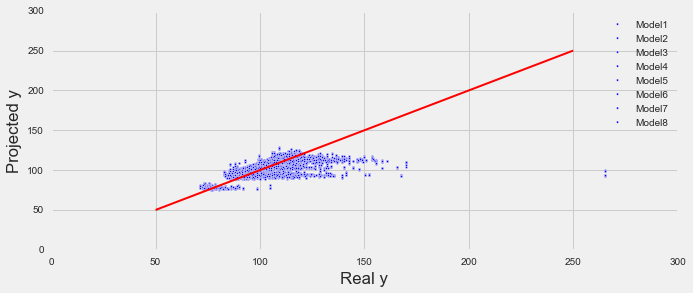

In [29]:
# Get error of each OOF column
preds_X_test = []
targets_X_test = []
for col in level_one_preds.columns :
    cv_score = r2_score(level_one_targets[col], level_one_preds[col])
    print("Global OOF r2_score for " + col + " : " + str(cv_score))
    preds_X_test.append(level_one_preds[col])
    targets_X_test.append(level_one_targets[col])
plot_preds(targets_X_test, preds_X_test)


In [30]:
# Optimize weights
bestSC, bestWght = optimize(preds_X_test)


 Ensemble Score: 0.5687610790429573

 Best Weights: [ 0.06082568  0.20673381  0.22521356  0.18430396  0.07394248  0.
  0.00545289  0.24633437]


In [31]:
# Prepare submission using optimal weights
preds = 0
for i in range(0, len(bestWght)) :
    preds = preds + (bestWght[i] * level_one_test[[i]].values)

In [34]:
# Save predictions
file_name = "ens_preds/avg_" + str(level_one_preds.shape[1]) + ".csv"
pd.DataFrame({"ID": init_test.ID.values, "y": pd.DataFrame(preds)[0]}).to_csv(file_name, index = False)


In [35]:
pd.DataFrame(preds)[0]

0       75.869
1       94.291
2       77.956
3       77.271
4      114.100
5       93.667
6      113.801
7       95.172
8      116.766
9       95.043
10     116.142
11     109.934
12     102.481
13      96.402
14     105.086
15     104.361
16     117.937
17     104.775
18      96.539
19      94.700
20     101.898
21     101.298
22      94.640
23      96.745
24      93.028
25     121.351
26     102.492
27     104.371
28      94.054
29      78.251
         ...  
4179   110.928
4180   102.515
4181    93.787
4182    93.234
4183   102.522
4184   110.729
4185    92.613
4186    93.629
4187   111.179
4188   110.612
4189    92.782
4190   113.833
4191    92.579
4192   103.548
4193    93.300
4194   111.808
4195    93.919
4196   103.679
4197   102.712
4198   113.827
4199    92.784
4200    92.125
4201    93.635
4202   111.842
4203   110.247
4204   103.704
4205    95.178
4206    93.467
4207   110.990
4208    93.383
Name: 0, dtype: float64

In [ ]:
'''# Get validation set data
la_preds_X_test = np.array(pd.read_csv("preds/la_preds_X_test.csv", header = None))
et_preds_X_test = np.array(pd.read_csv("preds/et_preds_X_test.csv", header = None))
xg_preds_X_test = np.array(pd.read_csv("preds/xg_preds_X_test.csv", header = None))

# Get test set data
la_preds_test = np.array(pd.read_csv("preds/la_preds_test.csv"))
et_preds_test = np.array(pd.read_csv("preds/et_preds_test.csv"))
xg_preds_test = np.array(pd.read_csv("preds/xg_preds_test.csv"))

preds_X_test = []
preds_X_test.append(la_preds_X_test[:, 0])
preds_X_test.append(et_preds_X_test[:, 0])
preds_X_test.append(xg_preds_X_test[:, 0])

preds_test = []
preds_test.append(la_preds_test[:, 1])
preds_test.append(et_preds_test[:, 1])
preds_test.append(xg_preds_test[:, 1])

names = []
names.append("la")
names.append("et")
names.append("xg")'''


In [ ]:
'''# Scores of single models on validation set
print("la on held out fold : " + str(r2_score(X_test_y, la_preds_X_test)))
print("et on held out fold : " + str(r2_score(X_test_y, et_preds_X_test)))
print("xg on held out fold : " + str(r2_score(X_test_y, xg_preds_X_test)))'''


In [ ]:
'''# Optimize weights
bestSC, bestWght, names = optimize(preds_X_test, names)'''

In [ ]:
'''# Prepare submission using optimal weights
preds = 0
for i in range(0, len(bestWght)) :
    (bestWght[i] * preds_test[i])
    preds += (bestWght[i] * preds_test[i])'''

In [ ]:
'''# Save predictions
pd.DataFrame({"ID": test_ids[0], "y": preds}).to_csv("preds/blend.csv", index = False)'''
